## Objective
Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
The objective of this project is to use existing data from users on the newer plan to develop a model that would recommend either the smart or ultra plan based on the user behaviours and usage.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
print(sklearn.__version__)

1.0.2


In [4]:
#import sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, learning_curve



In [5]:
print(sklearn.__version__)

1.0.2


In [6]:
#load data
try:
    df= pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

## Data check

In [7]:
#view data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [8]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [9]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [10]:
#check for missing values
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [11]:
#check for duplicates
df.duplicated().sum()

0

The data has been preprocessed in and cleaned, this was confirmed.
  * The data has no missing value
  * The right data are of the right type and expected values (no negative value)
  * There are no duplicate rows
  * The is_ultra column is used to identify the user's plan where 1 mean that the user uses ultra and 0 means the user uses Smart

### Split out Train, Validation and Test data for final model evaluation

In [12]:
#set features and target 
y=df['is_ultra']
X=df.drop(columns=['is_ultra'])

In [13]:
#split data into train and test data set
X_train, X_test, y_train, y_test= train_test_split(X, y, 
                                                   test_size=0.15, 
                                                   random_state=47, 
                                                   shuffle=True)

#split train data into train and validation data set
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train,
                                                 test_size=0.20,
                                                 random_state=47)


print(f'The train set now contains {len(X_train)} rows representing {int(len(X_train)*100/len(df))}% of the received data') 
print(f'The valid set now contains {len(X_val)} rows representing {int(len(X_val)*100/len(df))}% of the received data')
print(f'The test set now contains {len(X_test)} rows representing {int(len(X_test)*100/len(df))}% of the received data')

The train set now contains 2184 rows representing 67% of the received data
The valid set now contains 547 rows representing 17% of the received data
The test set now contains 483 rows representing 15% of the received data


In [14]:
#check for percentage class representation
y_train.value_counts()*100/len(y_train)

0    69.368132
1    30.631868
Name: is_ultra, dtype: float64

Data was shuffled and 15% taken out for final test dataset. 
The remaining data set was was the training and validation dataset.
The dataset is imbalanced as seen in the percentage of class representation

## Model Baseline

In [15]:
#train dummy  model on train dataset
dummy_model= DummyClassifier( strategy='most_frequent', random_state=47)
dummy_model.fit(X_train, y_train)

#check dummy model performance on validation dataset
dummy_accuracy= accuracy_score(y_val, dummy_model.predict(X_val))
dummy_fscore= f1_score(y_val, dummy_model.predict(X_val))
print(f'Dummy model accuracy of {dummy_accuracy}')
print(f'Dummy model an f score of {dummy_fscore}')

Dummy model accuracy of 0.6892138939670932
Dummy model an f score of 0.0


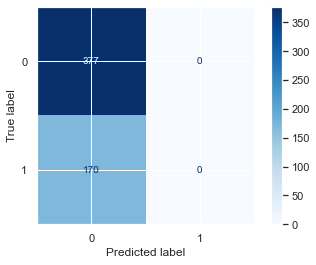

In [16]:
cm = confusion_matrix(y_val,dummy_model.predict(X_val), labels=dummy_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_model.classes_)
disp.plot(cmap='Blues')
plt.show()

The dummy model has an accuracy of of 0.69. The dummy model establishes the lowest baseline for the model we build. It is a classifier model that makes predictions without trying to find patterns in the data. 
The strategy used in training the model is assigninng the most frequent class for all prediction. 

The dummy model predicts that all customers are on the Smart plan. The f1 score is a better scoring method to evaluate our model. The model get an f1 score of 0 because if it fails to classify any Ultra user correctly and TP=0.


## Build Model

In [17]:
#standardize trainfeatures
scaler = StandardScaler()
scaled_features=scaler.fit_transform(X_train)
X_train=pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)

In [18]:
#standardize val features
scaled_val_features=scaler.transform(X_val)
X_val=pd.DataFrame(scaled_val_features, index=X_val.index, columns=X_val.columns)

In [19]:
#standardize test features
scaled_test_features=scaler.transform(X_test)
X_test=pd.DataFrame(scaled_test_features, index=X_test.index, columns=X_test.columns)

The scaling processes equilibrate the orders of magnittude of the variables involved in the model. The magnitude of the variables is important in distance based algorithm like the logistics regression. 

While this is not a requirement for tree based algorithms it helps them converge faster and help in determining feature importance , not based on magnitude of the feature but true impact.

# Test ML Algorithms and select best model

In [20]:
#print out model score
def model_score(best_model, X, y): 
    """
    This function takes a classfier model, the features and target data set as argument
    This function print out the model hyper parameter and the f1 and accuracy score for the given dataset
    """
    print('Model hyperparameter:', best_model)
    print()
    print('Model accuracy:', accuracy_score(y, best_model.predict(X)))
    print()
    print('F1_score:', f1_score(y, best_model.predict(X)))

### Random Forest Classifier

In [21]:
#tune RandomForest Classifier based onthe f1 score by looping through different hyperparameter values. 
#Select the model with the highest F1 score

best_score=0
rf_model= None

for depth in [10,20,30,40]:
    for est in [20,30,40]:
        for leaf in [3,4]:
            model=RandomForestClassifier(random_state=47, max_depth=depth, n_estimators=est, min_samples_leaf=leaf)
            model.fit(X_train, y_train)
            val_score= f1_score(y_val, model.predict(X_val))
            if val_score>best_score:
                best_score=val_score
                rf_model=model

                                


In [22]:
#randomforest validation score
model_score(rf_model, X_val, y_val)

Model hyperparameter: RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=30,
                       random_state=47)

Model accuracy: 0.8464351005484461

F1_score: 0.7272727272727274


### Logistics Regression

In [23]:
#tune Logistics Regression Classifier based onthe f1 score by looping through different hyperparameter values. 
#Select the model with the highest F1 score

best_score=0
lr_model= None

for itr in [5000,10000]:
    for sol in ['lbfgs', 'sag']:
        model=LogisticRegression(random_state=47, solver=sol, max_iter=itr)
        model.fit(X_train, y_train)
        val_score= f1_score(y_val, model.predict(X_val))
        if val_score > best_score:
            best_score= val_score
            lr_model=model

In [24]:
#LogisticRegression validation score
model_score(lr_model, X_val, y_val)

Model hyperparameter: LogisticRegression(max_iter=5000, random_state=47)

Model accuracy: 0.753199268738574

F1_score: 0.3946188340807175


### Naive Bayes

In [25]:
#initialize the classifer
nb_model= GaussianNB()

#train the model
nb_model.fit(X_train, y_train)

GaussianNB()

In [26]:
#Naive Bayes validation score
model_score(nb_model, X_val, y_val)

Model hyperparameter: GaussianNB()

Model accuracy: 0.7989031078610603

F1_score: 0.6206896551724139


Three model were created using the Naive bayes algorithm, LogisticRegression and RandomForest.
They were tuned based on the F1 score of the validation set by looping through set hperparameter and selecting the best performing combination.

The random forest model with hyperparameter RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators=40, random_state=47) is the best performing model with a validation f1 score of 0.67 and accuracy score of 0.83

## Final Model

In [27]:
#Test for overfitting and model learning curve on the test dataset

In [28]:


def draw_learning_curves(X, y, estimator, num_trainings):
    """
    The function accepts the features, target, model and number of sampled training as argument
    The model plot the learning curve of the model as number of samples increases for the training size
    to check for over fitting and underfitting  and also to know if training the model on more data will improve model
    performance
    
    Set scoring function based on use case
    """
    
   
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=1, scoring='f1_weighted',train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()

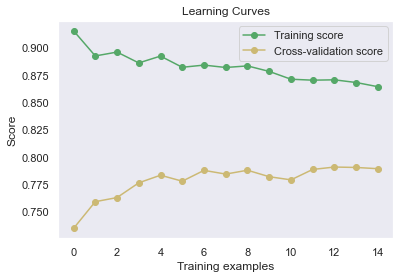

In [29]:
draw_learning_curves(X_train, y_train, rf_model, 15)

From the learning curve we see that the model slightly overfits the training set. However for our use case we will accept this performance.We also see that training the model with additional data might not improve the model's performance. 

In [30]:
print(classification_report(y_val, rf_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       377
           1       0.81      0.66      0.73       170

    accuracy                           0.85       547
   macro avg       0.83      0.79      0.81       547
weighted avg       0.84      0.85      0.84       547



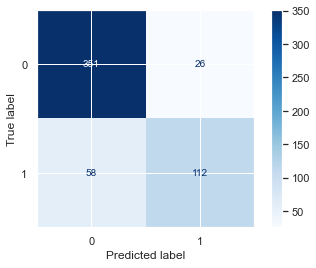

In [31]:
cm = confusion_matrix(y_val,rf_model.predict(X_val), labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.show()

The plot of the confusion matrix is consistent with the classsifaction report where we notice that the model classifies smart users better than it classifies ultra user. We should consider training the model on a dataset with more ultra user, this could improve model performance.

In [32]:
def build_roc_auc(model, X_train, X_test, y_train, y_test):
    '''
    INPUT: This function takes the model, the feature and target data set it was trained on 
    and the data set the model is to be evaluated on
    
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from scipy import interp
    
    y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))
    

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Well done!
</div>

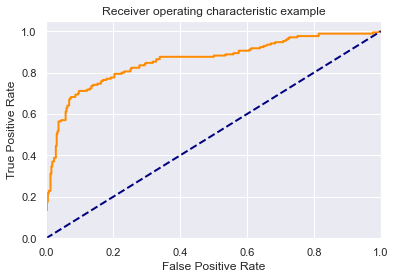

0.7949290060851926

In [33]:
# Finding validation roc and auc for the random forest model    
build_roc_auc(rf_model, X_train, X_val, y_train, y_val)

To further evaluate how well our model perform in splitting the target classes (for binary classifiers) for all different threshold values use to split the we plot the ROC curve and calculate the area under the curve. 

We have a Validation ROC-AUC of is 0.795, while a good model would typically have a score between 0.8 and 1, our model is close and is acceptable for our use case.

### Test data score

In [34]:
model_score(rf_model, X_test, y_test)

Model hyperparameter: RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=30,
                       random_state=47)

Model accuracy: 0.8115942028985508

F1_score: 0.6285714285714286


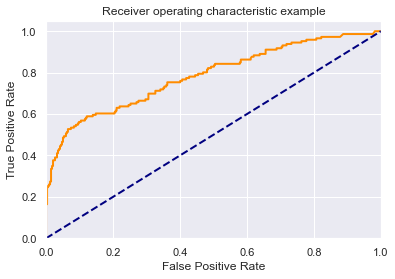

0.7310576805820902

In [35]:
# Finding test roc and auc for the random forest model    
build_roc_auc(rf_model, X_train, X_test, y_train, y_test)

We notice a drop in the AUC_ROC score to 0.73 for the test data. This shows that the model could be further improved as we want a score closer to 1 indicating a better split

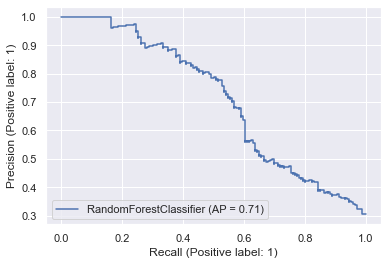

In [36]:
#plot PrecisionRecall Curve
PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

The precision recall curve showd the trade off between precision and recall at various thresholds used to split the data. Similar to the ROC curve we see that the model could be improved. We could adjust the threshold to prioritize either recall or precision but for our use case this isn't going to be done.

In [37]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       337
           1       0.78      0.53      0.63       146

    accuracy                           0.81       483
   macro avg       0.80      0.73      0.75       483
weighted avg       0.81      0.81      0.80       483



Final random forest model test score has an accuracy of 0.81 and and F1 score of 0.63 peforming better than the threshold of 0.75% for accuracy set by the business and the baseline established by the dummy model. Overall the model performance was consistent with was seen in the validation set as the model classified the smart users better than the ultra users

## Conclusion:

The data was clean and preprocessed, this was confirmed before futher analysis.The model will be evaluated using the accuracy_score.


The data was split into train validation and test set using the test_train_split method.
The dummy model had an accuracy of 0.69 and f1 score of 0 and established the lowest baseline for the model to be built.

Features and Target dataset were created. The features were standardized for good practice, while this is only needed for distance based algorithms it is good practice for others also as it helps them converges faster and also in feature importance selection.

We proceeded to build and tune several models by looping over set hyperparameter. The F1 score was uses as the scoring method and the best hyperparameter with the best F1 score was selected for each algorithm (RandomForest, Naive Bayes, LogisticRegression). The data is imbalance as such accuracy is poor estimate of the model performace for classifaction. The F1 score would be a better scoring method to assess the model performace. 

The random forest model with hyperparameter RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators=40, random_state=47) is the best performing model with a validation f1 score of 0.67 and accuracy score of 0.83

The model was further analyzed to check for overfitting. We noticed that the model slightly overfits the data but it is acceptable for our use case. we also noticed that the model performed better for the smart user class than the ultra user class. This could be because it was had more training on the smart user since it had more data and the opposite for ultra user.

Finally the validated model was evaluated on the test dataset to get the final test scores. The random forest model test score has an accuracy of 0.81 and and F1 score of 0.63 peforming better than the threshold of 0.75% for accuracy set by the business and the baseline established by the dummy model.


